# Import Library

In [ ]:
import zipfile, os, shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Data Loading and Exploration

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"waklenggazy","key":"9058875e35ad4a2baae1564860e3dc02"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fhabibimoghaddam/meta-stock-historical-prices-and-data2

  0% 0.00/30.8k [00:00<?, ?B/s]
100% 30.8k/30.8k [00:00<00:00, 1.53MB/s]


In [ ]:
local_zip = '/content/meta-stock-historical-prices-and-data2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
meta = pd.read_csv('META.csv')
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1509 non-null   object 
 1   Open       1509 non-null   float64
 2   High       1509 non-null   float64
 3   Low        1509 non-null   float64
 4   Close      1509 non-null   float64
 5   Adj Close  1509 non-null   float64
 6   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.6+ KB


In [ ]:
meta.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
meta.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,225.073857,228.245838,222.095328,225.212200,225.212200,2.414811e+07
std,68.302017,68.897817,67.640720,68.291138,68.291138,1.628735e+07
min,90.080002,90.459999,88.089996,88.910004,88.910004,5.467500e+06
25%,174.500000,176.899994,172.039993,174.600006,174.600006,1.539570e+07
50%,202.179993,204.910004,199.669998,202.259995,202.259995,2.008990e+07
75%,279.190002,285.239990,276.309998,281.000000,281.000000,2.788780e+07
max,381.679993,384.329987,378.809998,382.179993,382.179993,2.323166e+08


In [ ]:
meta.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-03,181.880005,184.779999,181.330002,184.669998,184.669998,16886600
1,2018-01-04,184.899994,186.210007,184.100006,184.330002,184.330002,13880900
2,2018-01-05,185.589996,186.899994,184.929993,186.850006,186.850006,13574500
3,2018-01-08,187.199997,188.899994,186.330002,188.279999,188.279999,17994700
4,2018-01-09,188.699997,188.800003,187.100006,187.869995,187.869995,12393100


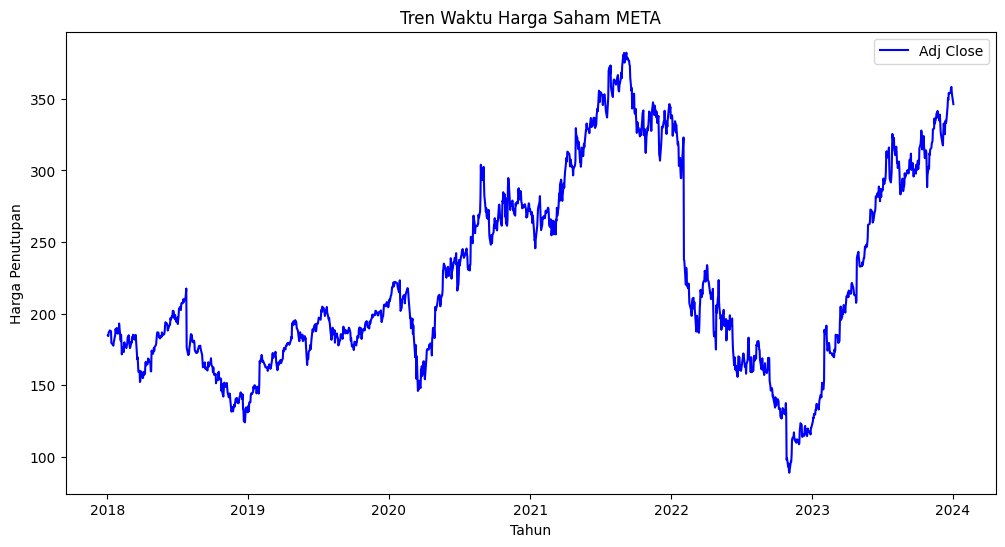

In [ ]:
# Mengonversi tipe data 'Date' ke datetime
meta['Date'] = pd.to_datetime(meta['Date'])

# Membuat grafik tren waktu menggunakan 'Adj Close'
plt.figure(figsize=(12, 6))
plt.plot(meta['Date'], meta['Adj Close'], label='Adj Close', color='blue')
plt.title('Tren Waktu Harga Saham META')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()


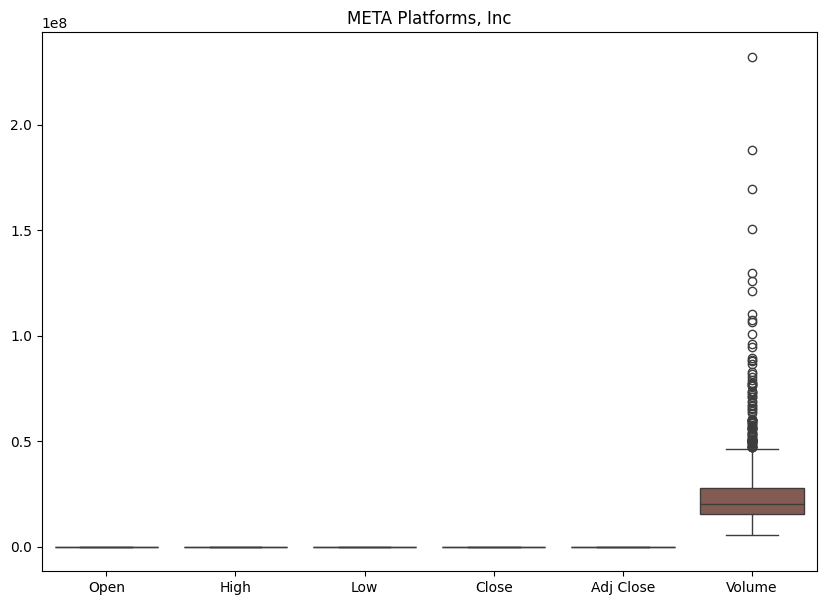

In [ ]:
# Memvisualisasikan distribusi data dan outlier
plt.subplots(figsize=(10,7))
sns.boxplot(data=meta).set_title("META Platforms, Inc")
plt.show()

In [ ]:
# Hapus outlier menggunakan metode IQR
numeric_columns = meta.select_dtypes(include=['float64', 'int64']).columns
Q1 = meta[numeric_columns].quantile(0.25)
Q3 = meta[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
meta = meta[~((meta[numeric_columns] < (Q1 - 1.5 * IQR)) | (meta[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(meta.shape)

(1422, 7)


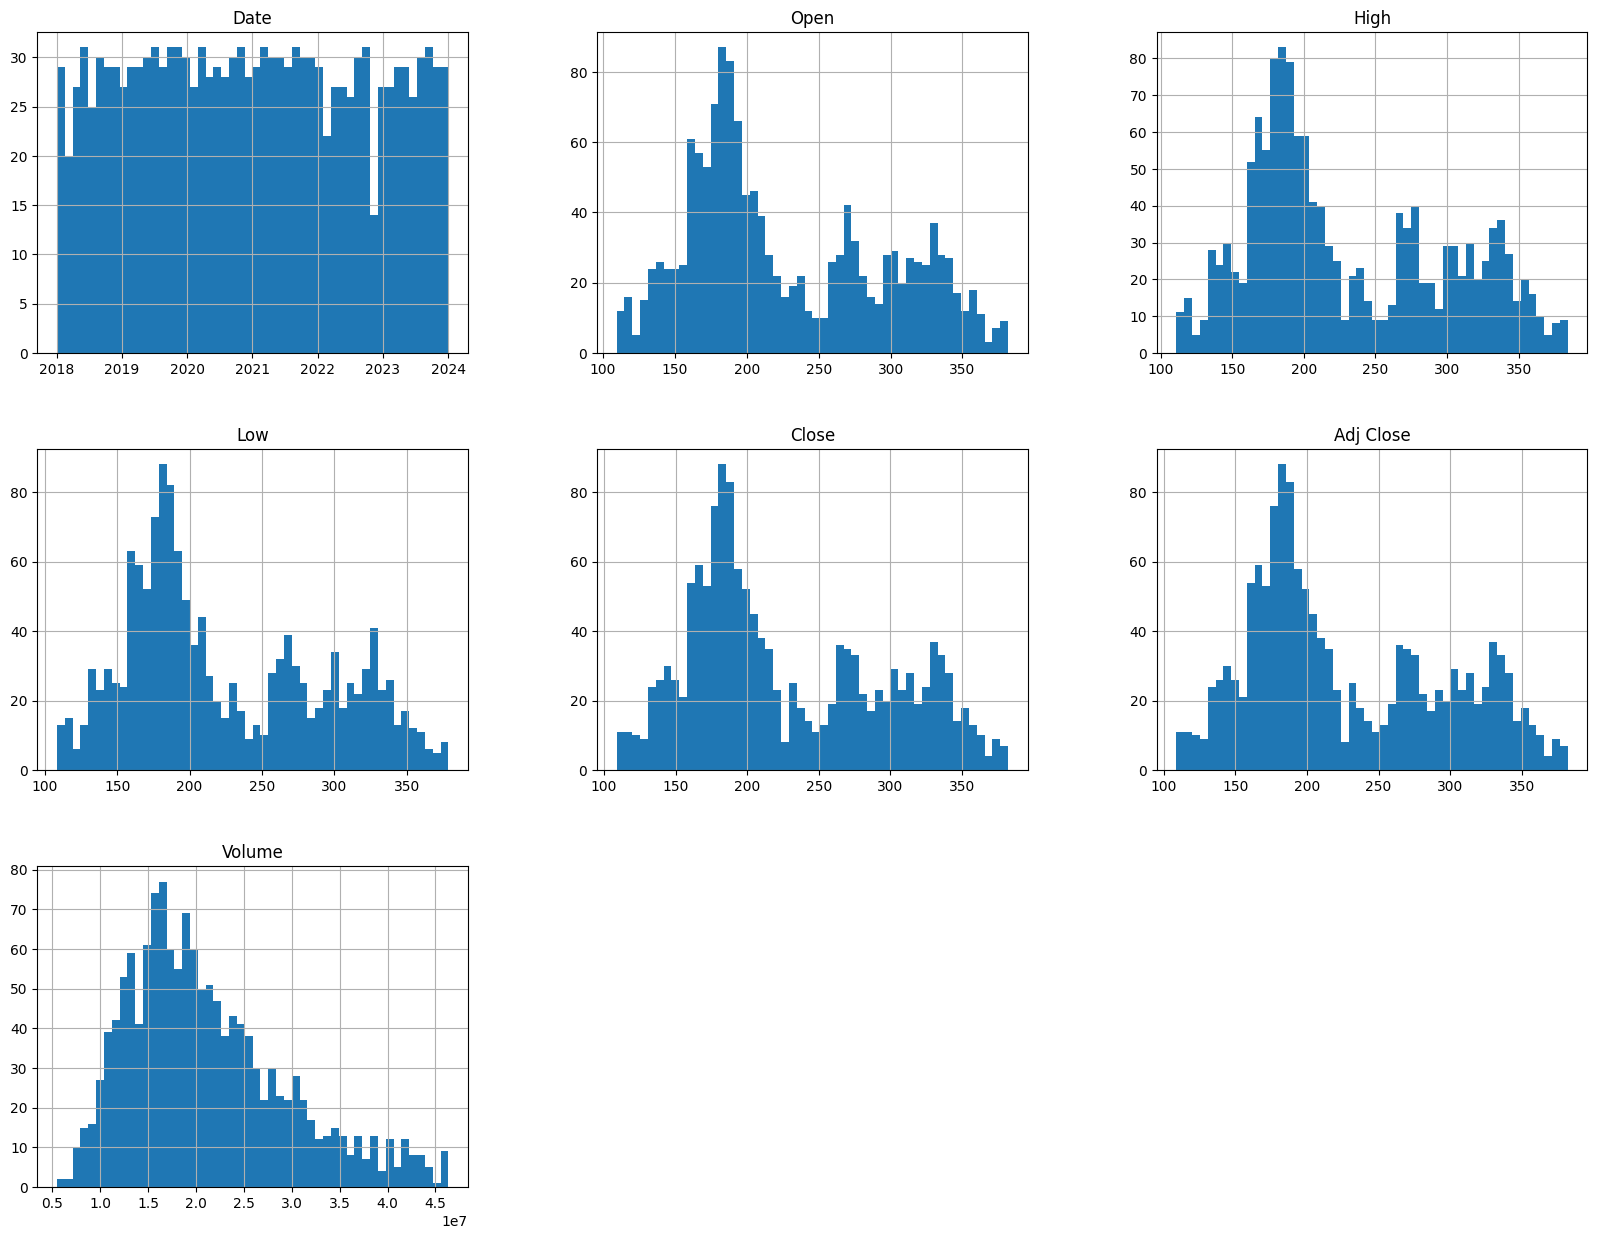

In [ ]:
# Histogram fitur Numerik
meta.hist(bins=50, figsize=(20,15))
plt.show()

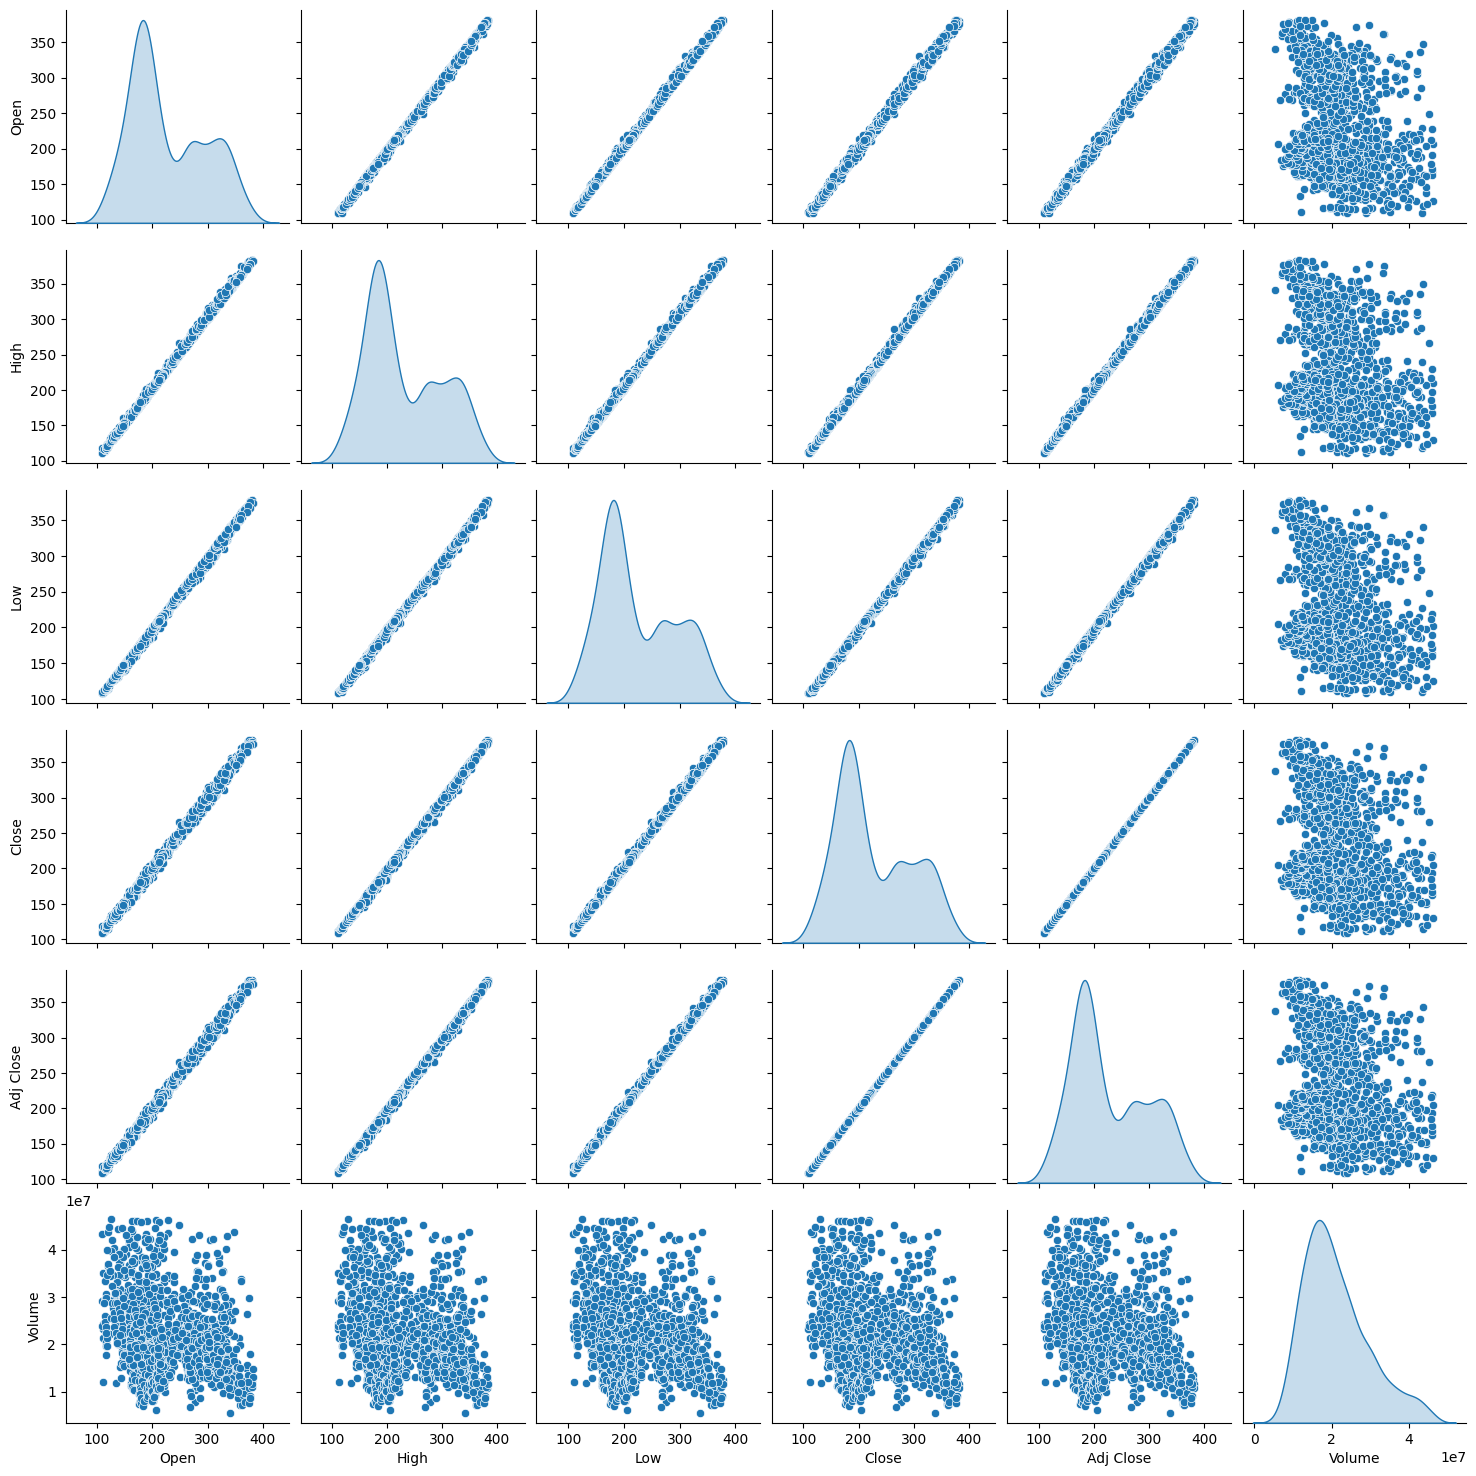

In [ ]:
# Memvisualisasikan hubungan antar fitur
sns.pairplot(meta, diag_kind = 'kde')

<ipython-input-73-7a5c76f6e097>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = meta.corr().round(2)


Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

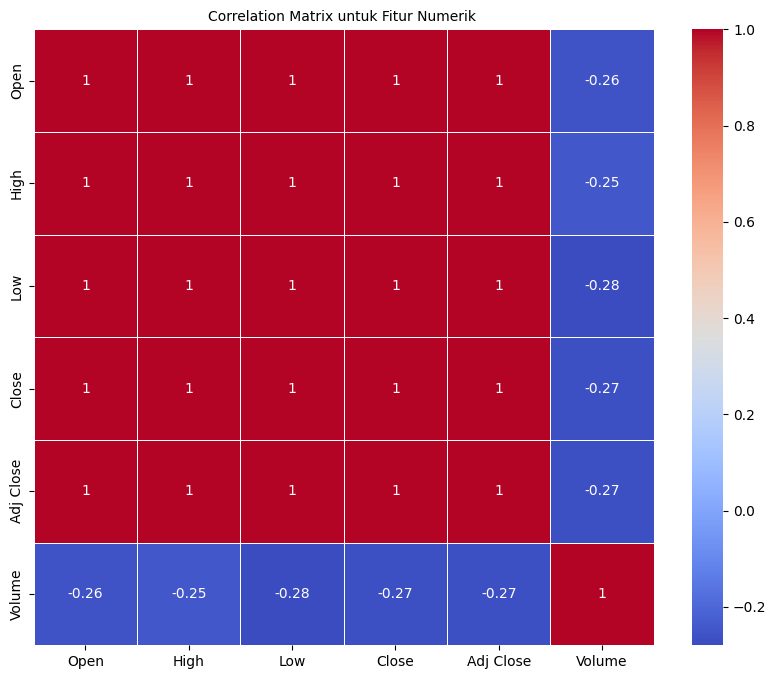

In [ ]:
# Memvisualisasikan matriks korelasi
plt.figure(figsize=(10, 8))
correlation_matrix = meta.corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=10)

# Data Preprocessing

In [ ]:
# Menghapus fitur yang tidak diperlukan
meta = meta.drop(['Date', 'Volume', 'Close'], axis=1)
meta.head()

,Open,High,Low,Adj Close
0,181.880005,184.779999,181.330002,184.669998
1,184.899994,186.210007,184.100006,184.330002
2,185.589996,186.899994,184.929993,186.850006
3,187.199997,188.899994,186.330002,188.279999
4,188.699997,188.800003,187.100006,187.869995


In [ ]:
meta.describe()

,Open,High,Low,Adj Close
count,1422.000000,1422.000000,1422.000000,1422.000000
mean,227.441632,230.524564,224.561575,227.588896
std,67.965613,68.616091,67.308324,67.977966
min,109.510002,110.940002,108.320000,108.779999
25%,175.997505,178.174999,174.049996,176.080005
50%,203.404999,205.900001,201.160004,203.584999
75%,283.510002,288.307511,278.597496,283.857506
max,381.679993,384.329987,378.809998,382.179993


In [ ]:
# Memisahkan fitur (X) dan variabel target (y)
X = meta.iloc[:, :-1].values
y = meta.iloc[:, -1].values

In [ ]:
# Melakukan pembagian dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'Total Dataset: {len(X)}')
print(f'Total Train Dataset: {len(X_train)}')
print(f'Total Test Dataset: {len(X_test)}')

Total Dataset: 1422
Total Train Dataset: 1137
Total Test Dataset: 285


# Model Selection and Training

In [ ]:
# Menskalakan fitur
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Buat DataFrame untuk menyimpan metrik kinerja model
models = pd.DataFrame(columns=['train_mse', 'test_mse'], index=['SVR', 'KNN', 'GradientBoosting'])

In [ ]:
# Fungsi untuk melakukan pencarian Grid
def grid_search(model, hyperparameters):
  results = GridSearchCV(
      model,
      hyperparameters,
      cv=5,
      verbose=1,
      n_jobs=6
  )

  return results

In [ ]:
# Melakukan pencarian Grid untuk SVR
svr = SVR()
hyperparameters = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 10, 100, 1000],
    'gamma': [0.3, 0.03, 0.003, 0.0003]
}

svr_search = grid_search(svr, hyperparameters)
svr_search.fit(X_train, y_train)
print(svr_search.best_params_)
print(svr_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 1000, 'gamma': 0.3, 'kernel': 'rbf'}
0.999295436182431


In [ ]:
# Melakukan pencarian grid untuk Gradient Boosting
gradient_boost = GradientBoostingRegressor()
hyperparameters = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'n_estimators': [250, 500, 750, 1000],
    'criterion': ['friedman_mse', 'squared_error']
}

gradient_boost_search = grid_search(gradient_boost, hyperparameters)
gradient_boost_search.fit(X_train, y_train)
print(gradient_boost_search.best_params_)
print(gradient_boost_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'criterion': 'squared_error', 'learning_rate': 0.01, 'n_estimators': 1000}
0.9987650338382295


In [ ]:
# Melakukan pencarian grid untuk KNN
knn = KNeighborsRegressor()
hyperparameters = {
    'n_neighbors': range(1, 10)
}

knn_search = grid_search(knn, hyperparameters)
knn_search.fit(X_train, y_train)
print(knn_search.best_params_)
print(knn_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'n_neighbors': 4}
0.9988996830275287


In [ ]:
# Inisialisasi dan latih model SVR
svr = SVR(C=10, gamma=0.3, kernel='rbf')
svr.fit(X_train, y_train)

SVR(C=10, gamma=0.3)

In [ ]:
# Inisialisasi dan latih model Gradient Boosting
gradient_boost = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01, n_estimators=1000)
gradient_boost.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01,
                          n_estimators=1000)

In [ ]:
# Inisialisasi dan latih model KNN
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

# Model Evaluation

In [ ]:
# Buat kamus untuk menyimpan model
model_dict = {
    'SVR': svr,
    'GradientBoosting': gradient_boost,
    'KNN': knn,
}

# Evaluasi kinerja setiap model pada data pelatihan dan pengujian
for name, model in model_dict.items():
  models.loc[name, 'train_mse'] = mean_squared_error(y_train, model.predict(X_train))
  models.loc[name, 'test_mse'] = mean_squared_error(y_test, model.predict(X_test))

models.head()

,train_mse,test_mse
SVR,13.521845,16.769305
KNN,3.954466,5.931945
GradientBoosting,2.236794,6.715785


# Visualization of Model Comparison



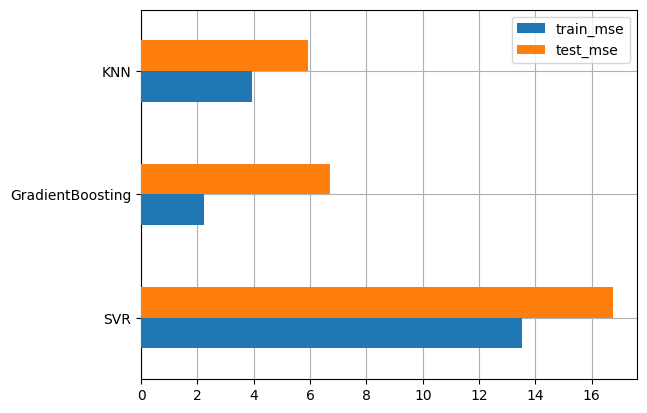

In [ ]:
# Plot perbandingan kinerja model
fig, ax = plt.subplots()
models.sort_values(by='test_mse', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

# Prediction

In [ ]:
# Pilih subset data uji untuk prediksi
num_rows_to_predict = 1
X_test_subset = X_test[:num_rows_to_predict, :]
y_test_subset = y_test[:num_rows_to_predict]

# Buat kamus untuk menyimpan nilai benar dan prediksi
pred_dict = {'y_true': y_test_subset}

# Buat prediksi dari setiap model
for name, model in model_dict.items():
    predictions = model.predict(X_test_subset).round(1)
    pred_dict['prediksi_' + name] = predictions

pd.DataFrame(pred_dict)

,y_true,prediksi_SVR,prediksi_GradientBoosting,prediksi_KNN
0,177.970001,177.3,178.9,178.4
